In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'

adata = sc.read_h5ad(results_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
# subset to T cells
# also remove the BN/PIN sample
lymphoid = adata[(adata.obs['celltype'].isin(['T cell', 'B cell', 'NK cell'])) & ~(adata.obs['highest_GLEASON_score'] == 'BN+PIN')]
# lymphoid = adata[(adata.obs['celltype'].isin(['T cell', 'B cell', 'NK cell']))]
lymphoid

View of AnnData object with n_obs × n_vars = 2275 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
# make a copy?
adata = sc.AnnData(lymphoid.raw.X, obs = lymphoid.obs, var = lymphoid.raw.var, uns = lymphoid.uns)
adata.raw = adata

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


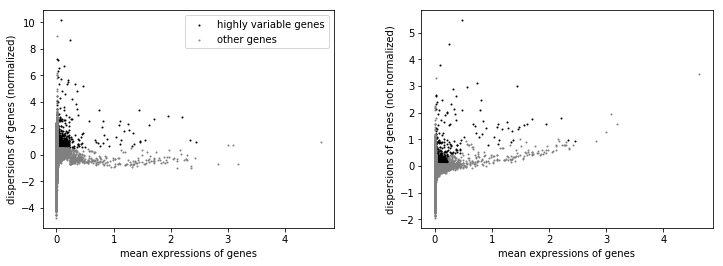

In [4]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [5]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]

In [6]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack', n_comps = 50)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


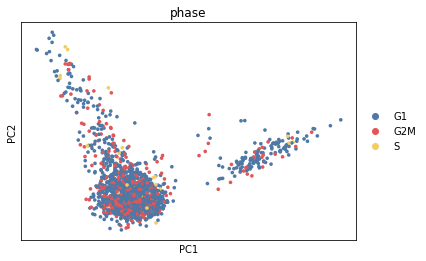

In [7]:
sc.pl.pca(adata, color = 'phase')

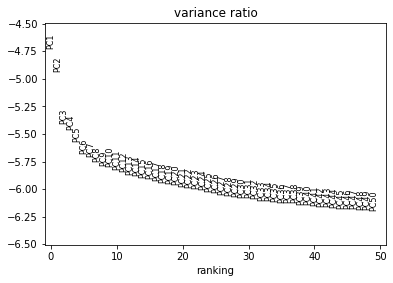

In [8]:
# Principal component analysis
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


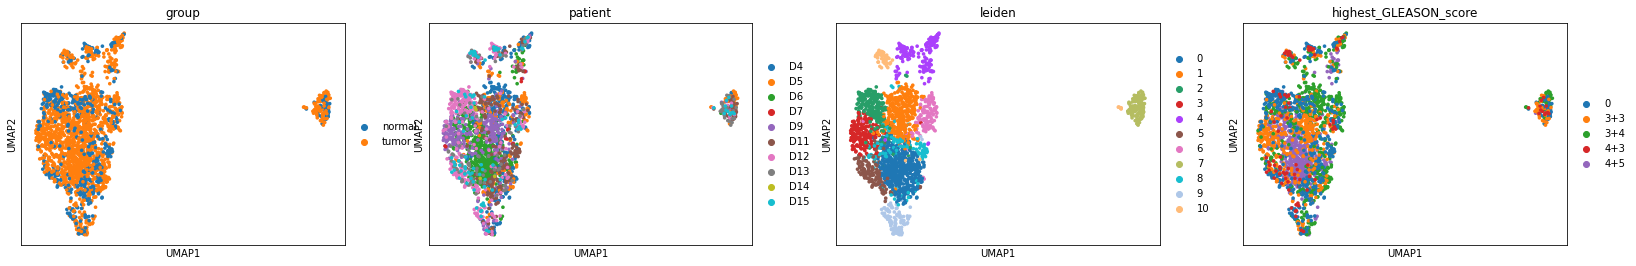

In [9]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata)
# plotting groups and clusters
sc.pl.umap(adata, color = ['group', 'patient', 'leiden', 'highest_GLEASON_score'])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


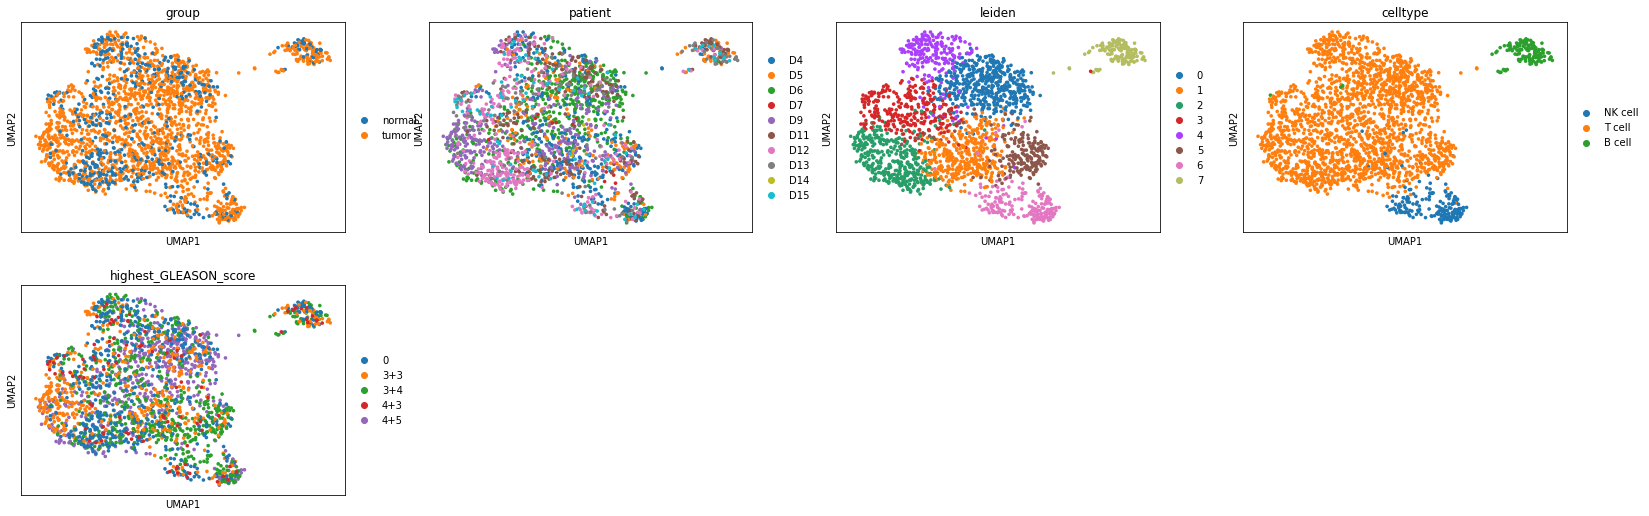

In [12]:
# batch correction using bbknn
sc.external.pp.bbknn(adata, batch_key = 'patient')
# rerun umap
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata)
sc.pl.umap(adata, color = ['group', 'patient', 'leiden', 'celltype', 'highest_GLEASON_score'])

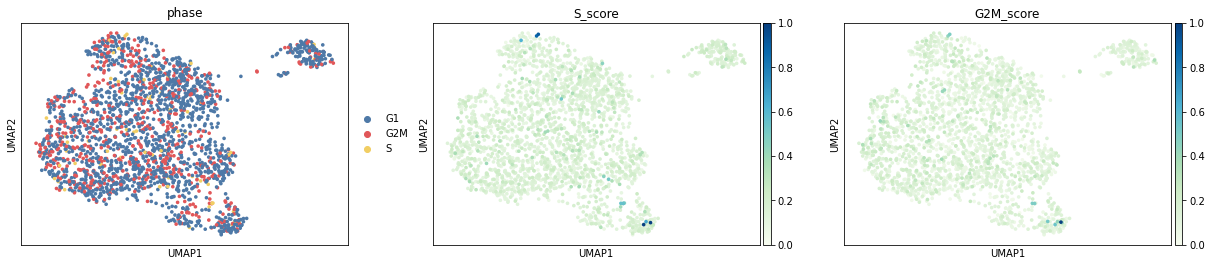

In [13]:
sc.pl.umap(adata, color = ['phase', 'S_score', 'G2M_score'], groups=['G1', 'G2M','S'], color_map = 'GnBu')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


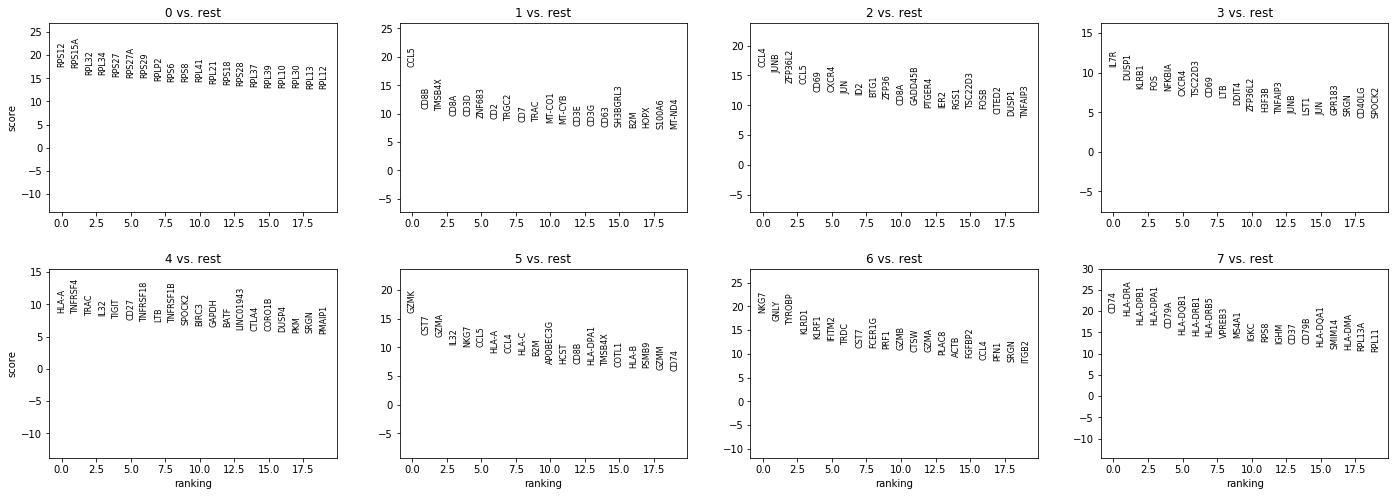

In [282]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon', n_genes=30000)
sc.pl.rank_genes_groups(adata, ngenes = 25, sharey = False)

In [283]:
# save
adata.write('out/lymphoid.h5ad', compression = 'gzip')

In [14]:
lymphoid_file = 'out/lymphoid.h5ad'
adata = sc.read_h5ad(lymphoid_file)
adata

AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [17]:
# transfer these slots to a raw object
adata_raw = sc.read_h5ad('out/prostate_raw.h5ad')
adata_raw = adata_raw[(adata_raw.obs['celltype'].isin(['Tcell', 'Bcell', 'NKcell'])) & ~(adata_raw.obs['highest_GLEASON_score'] == 'BN+PIN')]
adata_raw.obs = adata.obs
adata_raw.obs['cohort'] = 'UCAM'
adata_raw.obsm = adata.obsm
adata_raw.uns = adata.uns

In [18]:
# save
adata_raw.write('out/lymphoid_raw.h5ad', compression = 'gzip')

... storing 'cohort' as categorical


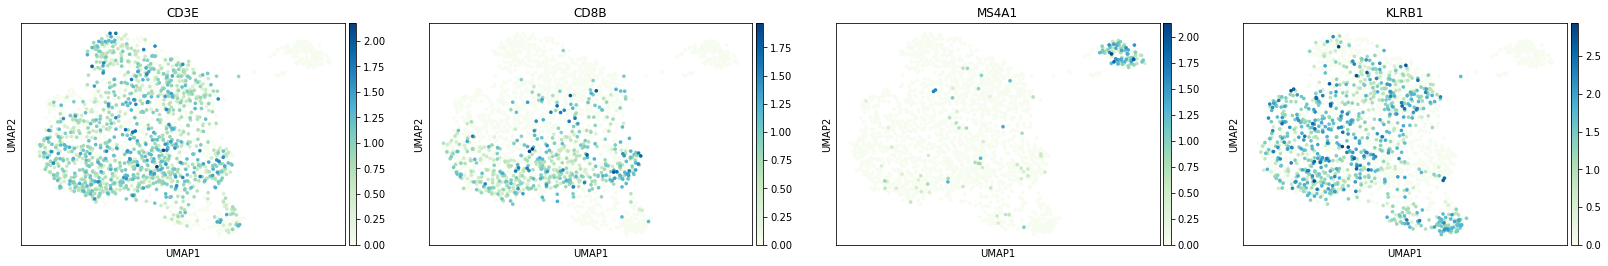

In [303]:
sc.pl.umap(adata, color = ['CD3E', 'CD8B', 'MS4A1', 'KLRB1'], color_map = 'GnBu')

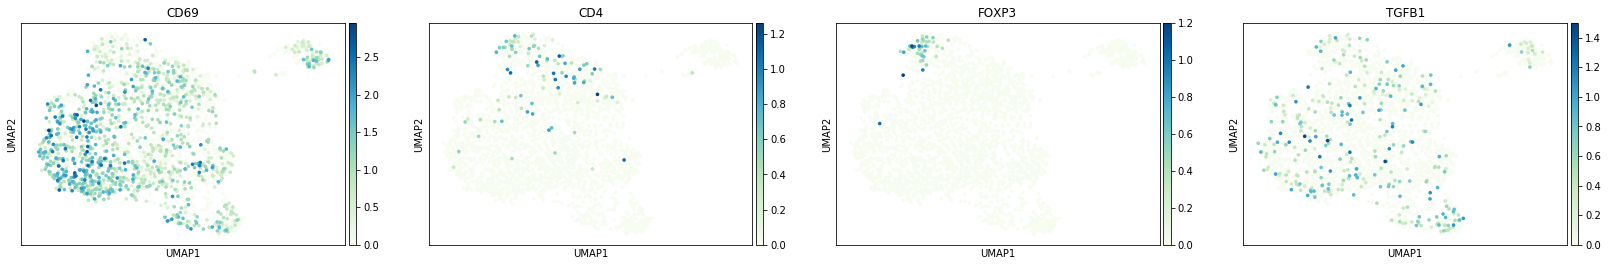

In [302]:
sc.pl.umap(adata, color = ['CD69', 'CD4', 'FOXP3', 'TGFB1'], color_map = 'GnBu')

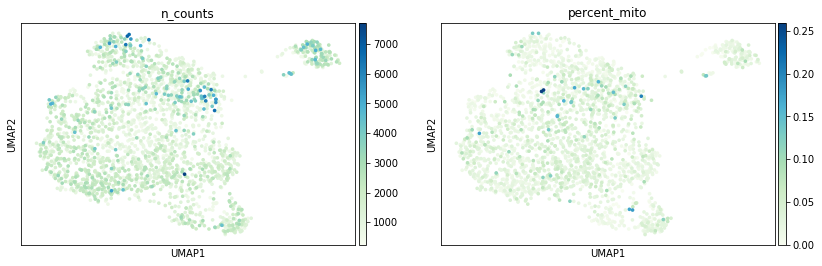

In [301]:
sc.pl.umap(adata, color = ['n_counts', 'percent_mito'], color_map = 'GnBu')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: CD8T, CD8 Trm, Naive/Mem CD4T, etc.


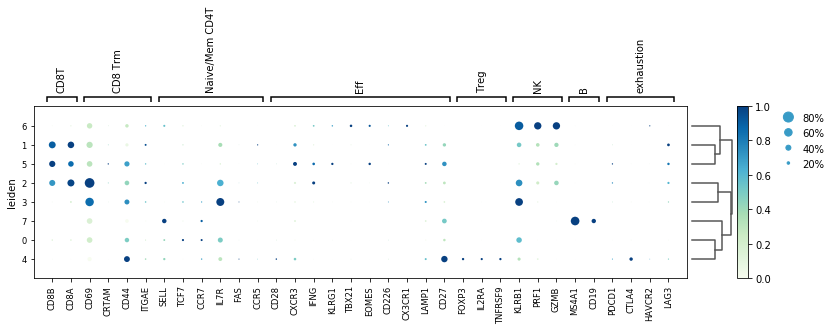

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[11.899999999999999, 0.8, 0.2, 0.5, 0.25])

In [300]:
sc.tl.dendrogram(adata, groupby = 'leiden')
# plot some marker genes
genes = {
    'CD8T':['CD8B', 'CD8A'],
    'CD8 Trm':['CD69', 'CRTAM', 'CD44', 'ITGAE'],
    'Naive/Mem CD4T':['SELL','TCF7','CCR7','IL7R', 'FAS', 'CCR5'],
    'Eff':['CD28', 'CXCR3', 'IFNG', 'KLRG1', 'TBX21', 'EOMES', 'CD226', 'CX3CR1', 'LAMP1', 'CD27'],
    'Treg':['FOXP3', 'IL2RA', 'TNFRSF9'],
    'NK':['KLRB1','PRF1', 'GZMB'],
    'B':['MS4A1', 'CD19'],
    'exhaustion':['PDCD1','CTLA4','HAVCR2','LAG3']}
sc.pl.dotplot(adata, genes, groupby = 'leiden', color_map = 'GnBu', standard_scale = 'var', dendrogram = True)

categories: 0, 1, 2, etc.
var_group_labels: CD8T, CD8 Trm, Naive/Mem CD4T, etc.


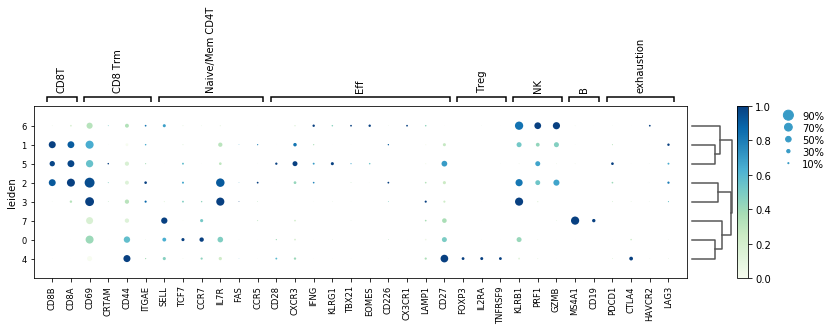

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[11.899999999999999, 0.8, 0.2, 0.5, 0.25])

In [299]:
# split to just normal
sc.pl.dotplot(adata[adata.obs['group'] == 'normal'], genes, groupby = 'leiden', color_map = 'GnBu', standard_scale = 'var', dendrogram = True)

categories: 0, 1, 2, etc.
var_group_labels: CD8T, CD8 Trm, Naive/Mem CD4T, etc.


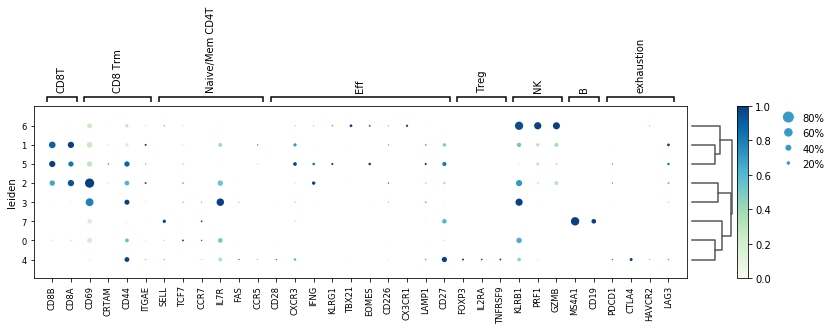

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[11.899999999999999, 0.8, 0.2, 0.5, 0.25])

In [298]:
# split to just tumor
sc.pl.dotplot(adata[adata.obs['group'] == 'tumor'], genes, groupby = 'leiden', color_map = 'GnBu', standard_scale = 'var', dendrogram = True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


Trying to set attribute `.uns` of view, making a copy.


categories: 0, 1, 2, etc.
var_group_labels: CD4 rest, CD4 act
, CD4 Trm rest, etc.


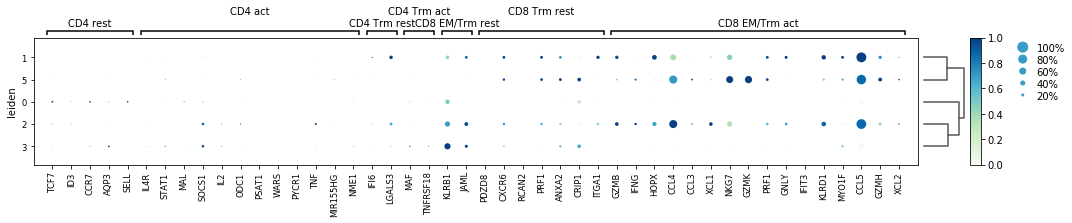

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[16.099999999999998, 0.8, 0.2, 0.5, 0.25])

In [353]:
# try markers From Dona Farber's recent paper
tcell_markers = {
    'CD4 rest':['TCF7', 'ID3', 'CCR7', 'AQP3', 'SELL'],
    'CD4 act\n':['IL4R', 'STAT1', 'MAL', 'SOCS1', 'IL2', 'ODC1', 'PSAT1', 'WARS', 'PYCR1', 'TNF', 'MIR155HG', 'NME1'],
    'CD4 Trm rest':['IFI6', 'LGALS3'],
    'CD4 Trm act\n':['MAF', 'TNFRSF18'],
    'CD8 EM/Trm rest':['KLRB1', 'JAML'],
    'CD8 Trm rest\n':['PDZD8', 'CXCR6', 'RCAN2', 'PRF1', 'ANXA2', 'CRIP1', 'ITGA1'],
    'CD8 EM/Trm act':['GZMB', 'IFNG', 'HOPX', 'CCL4', 'CCL3', 'XCL1', 'NKG7', 'GZMK', 'PRF1', 'GNLY', 'IFIT3', 'KLRD1', 'MYO1F', 'CCL5', 'GZMH', 'XCL2']}
# remove obvious Treg, NK and B cells
adata2 = adata[~adata.obs['leiden'].isin(['4', '6', '7'])]
sc.tl.dendrogram(adata2, groupby = 'leiden')
sc.pl.dotplot(adata2, tcell_markers, groupby = 'leiden', color_map = 'GnBu', standard_scale = 'var', dendrogram = True, var_group_rotation = 0)

In [307]:
# try gene set test with Dona Farber's recent paper
modules = pd.read_csv('dataset/Szabo et al T cell gene module.txt', sep = '\t')
for gs in modules.columns:
    sc.tl.score_genes(adata2, modules[gs], score_name = str(gs)+'_score', use_raw=True)

computing score 'Treg_score'
    finished: added
    'Treg_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 NV/CM rest_score'
    finished: added
    'CD4 NV/CM rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4/CD8 rest_score'
    finished: added
    'CD4/CD8 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'IFN Response_score'
    finished: added
    'IFN Response_score', score of gene set (adata.obs) (0:00:00)
computing score 'Proliferation_score'
    finished: added
    'Proliferation_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytotoxic_score'
    finished: added
    'CD8 Cytotoxic_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytokine_score'
    finished: added
    'CD8 Cytokine_score', score of gene set (adata.obs) (0:00:00)


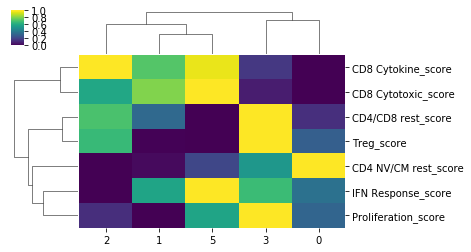

In [322]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['leiden'] + [str(gs)+'_score' for gs in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetX = subset[subset.leiden == x]
    outdict = {}
    for k in [str(gs)+'_score' for gs in modules.columns]:
        out = {k:np.mean(subsetX[k])}
        outdict.update(out)
    output = output.append(outdict, ignore_index=True)
output.index = list1
g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(6, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score.pdf')

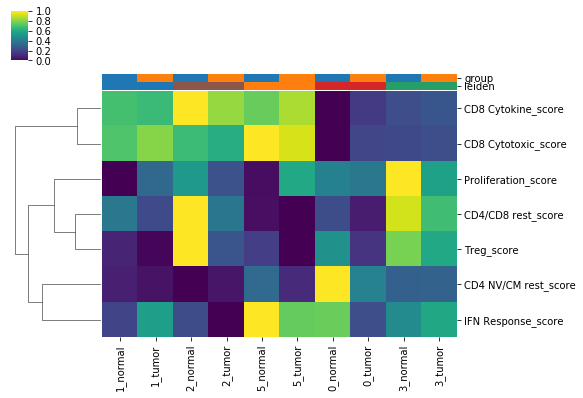

In [325]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in modules.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset.leiden == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset.leiden == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in adata2.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata2.uns['leiden_colors']) + list(adata2.uns['leiden_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'leiden']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['1_normal', '1_tumor', '2_normal', '2_tumor', '5_normal', '5_tumor', '0_normal', '0_tumor', '3_normal', '3_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_split.pdf')

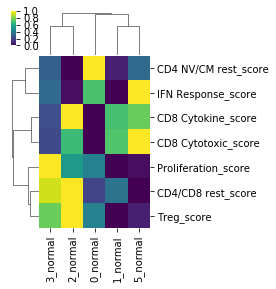

In [321]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset.leiden == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_normal.pdf')

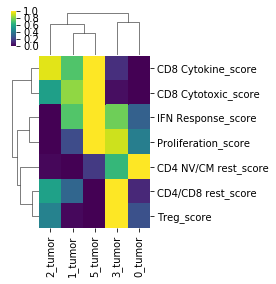

In [320]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetT = subset[(subset.group == 'tumor') & (subset.leiden == x)]
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outT = {k:np.mean(subsetT[k])}
        outdictT.update(outT)
    output = output.append(outdictT, ignore_index=True)
output.index = [l + '_tumor' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_tumor.pdf')

In [52]:
Kumar_Trm_signature = {'CD69+Trm':['CA10','ITGAE1','ITGAE','IL2','IL10','CXCR6','CXCL13','KCNK5','RGS1','CRTAM','DUSP6','PDCD1','IL23R'],
    'CD69-Trm':['STK38','TTC16','SELL','KLF3','KLF2','D4S234E','SBK1','FAM65B','TTYH2','NPDC1','KRT72','S1PR1','SOX13','KRT73','TSPAN18','PTGDS','RAP1GAP2','CX3CR1']}
Mackay_Trm_signature={
    'Trm':['INSIG1', 'DDX3X', 'DHCR24', 'PPP1R16B', 'KLF6', 'BTG2', 'CXCR6', 'FOSB', 'JUN', 'HSPA5', 'NEDD4', 'PLK3', 'STARD4', 'TNFAIP3', 'B4GALNT4', 'IRF4', 'CISH', 'MAPKAPK3', 'SIK1', 'PYGL', 'CTNNA1', 'ODC1', 'PER1', 'DUSP1', 'ATF3', 'LDLRAD4', 'JUNB', 'NFKBID', 'FOSL2', 'RGS2', 'NR4A2', 'DGAT1', 'ARRDC3', 'FRMD4B', 'NR4A1', 'GPR171', 'SMIM3', 'EYA2', 'GPR55', 'AL662899.4', 'CSRNP1', 'TRAF4', 'ZFP36', 'GLRX', 'DUSP5', 'LITAF', 'GADD45B', 'IFNG', 'OSGIN1', 'ABI3', 'EGR1', 'HILPDA', 'SKIL', 'RNF149', 'HMGCS1', 'P4HB', 'PNRC1', 'GPR34', 'PPP1R15A', 'ITGAE', 'P2RY10', 'EHD1', 'DUSP6', 'XCL2', 'SPSB1', 'ISG20', 'INPP4B', 'NEURL3', 'HPGDS', 'RHOB', 'VDAC1', 'LAD1', 'FOS', 'CDH1', 'CD69', 'QPCT', 'HSPD1'],
    'Tcm/Tem':['HBA2', 'C19orf38', 'SNX10', 'HAAO', 'POGK', 'SBK1', 'KLF2', 'BCL9L', 'THAP7', 'ASRGL1', 'ELMO1', 'HEXB', 'RACGAP1', 'CXCR4', 'CDC25B', 'LFNG', 'S1PR5', 'ARHGAP26', 'MPND', 'KCNAB2', 'ATP1B3', 'S1PR4', 'TMEM71', 'KBTBD11', 'EMB', 'MS4A4A', 'GRAMD4', 'EHD3', 'KCNN4', 'TCF7', 'MS4A4A', 'PAQR7', 'FAM89B', 'LYST', 'GLIPR2', 'EML3', 'S1PR1', 'PIK3R5', 'SETX', 'TXNDC5', 'NCLN', 'STK38', 'ITGA4', 'CCL5', 'CD84', 'KLF3', 'ABTB2', 'TBXA2R', 'LYRM2', 'OBP2B', 'ACP5', 'PODNL1', 'LEF1', 'SH2D1A', 'PHF11', 'TSR3', 'GMFG', 'EOMES', 'GNPDA2', 'PDE2A', 'SIDT1', 'GAB3', 'TXK', 'AVEN', 'ICAM2', 'KLHL6', 'SAMHD1', 'SMPDL3B', 'TTC7B', 'C5orf30', 'ATP10D', 'ST3GAL1', 'VOPP1', 'PCED1B', 'DOCK2', 'ITGB1', 'FAM117A', 'IL10RA', 'LPIN1', 'RBM43', 'ARHGEF18', 'RASA3', 'ABHD8', 'FAM49A', 'RASGRP2', 'B3GAT3', 'PRKCQ', 'XRN2']}
tcell_markers = {
    'CD4 rest':['TCF7', 'ID3', 'CCR7', 'AQP3', 'SELL'],
    'CD4 act\n':['IL4R', 'STAT1', 'MAL', 'SOCS1', 'IL2', 'ODC1', 'PSAT1', 'WARS', 'PYCR1', 'TNF', 'MIR155HG', 'NME1'],
    'CD4 Trm rest':['IFI6', 'LGALS3'],
    'CD4 Trm act\n':['MAF', 'TNFRSF18'],
    'CD8 EM/Trm rest':['KLRB1', 'JAML'],
    'CD8 Trm rest\n':['PDZD8', 'CXCR6', 'RCAN2', 'PRF1', 'ANXA2', 'CRIP1', 'ITGA1'],
    'CD8 EM/Trm act':['GZMB', 'IFNG', 'HOPX', 'CCL4', 'CCL3', 'XCL1', 'NKG7', 'GZMK', 'PRF1', 'GNLY', 'IFIT3', 'KLRD1', 'MYO1F', 'CCL5', 'GZMH', 'XCL2']}

In [53]:
for gs in Kumar_Trm_signature:
    sc.tl.score_genes(adata2, Kumar_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in Mackay_Trm_signature:
    sc.tl.score_genes(adata2, Mackay_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in tcell_markers:
    sc.tl.score_genes(adata2, tcell_markers[gs], score_name = str(gs)+'_score', use_raw=True)

computing score 'CD69+Trm_score'
    finished: added
    'CD69+Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD69-Trm_score'
    finished: added
    'CD69-Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Trm_score'
    finished: added
    'Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Tcm/Tem_score'
    finished: added
    'Tcm/Tem_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 rest_score'
    finished: added
    'CD4 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 act\n_score'
    finished: added
    'CD4 act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm rest_score'
    finished: added
    'CD4 Trm rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm act\n_score'
    finished: added
    'CD4 Trm act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 EM/Trm rest_score'
    finished: added
    'CD8 EM/

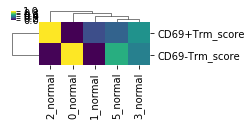

In [359]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in Kumar_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset.leiden == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Kumar_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Kumar_Trm_geneset_score_normal.pdf')

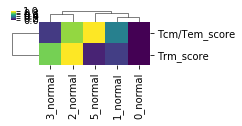

In [360]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in Mackay_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset.leiden == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Mackay_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Mackay_Trm_geneset_score_normal.pdf')

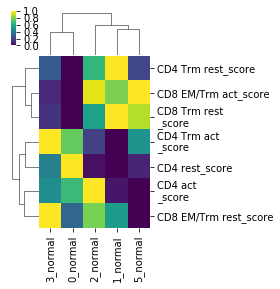

In [365]:
# calculate average enrichment score
list1 = list(set(adata2.obs['leiden']))
subset = adata2.obs[['group', 'leiden'] + [str(m)+'_score' for m in tcell_markers]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset.leiden == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in tcell_markers]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_tcell_marker_score_normal.pdf')

In [327]:
# sc.pl.dotplot(adata2[adata2.obs['group'] == 'tumor'], ['PDCD1', 'CTLA4', 'HAVCR2', 'LAG3'], groupby = 'leiden', color_map = 'viridis', standard_scale = 'var', dendrogram = True)

In [117]:
# so just based on normal, most likely
# '0':'CD4 naive/mem'
# '1':'CD8'
# '2':'CD8 Trm'
# '3':'CD4'
# '4':'Treg'
# '5':'CD8 act/em'
# '6':'NK cell'
# '7':'B cell'

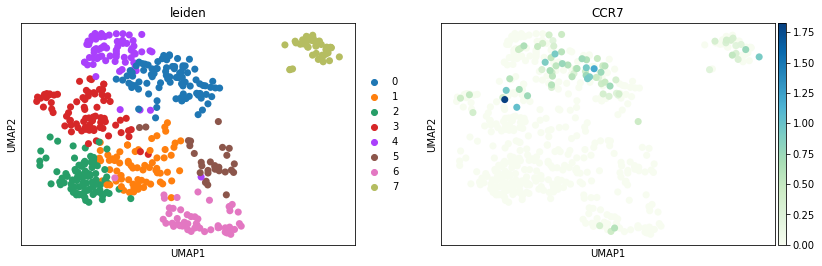

In [367]:
sc.pl.umap(adata[adata.obs['group'] == 'normal'], color = ['leiden', 'CCR7'], size = 200, color_map = 'GnBu')

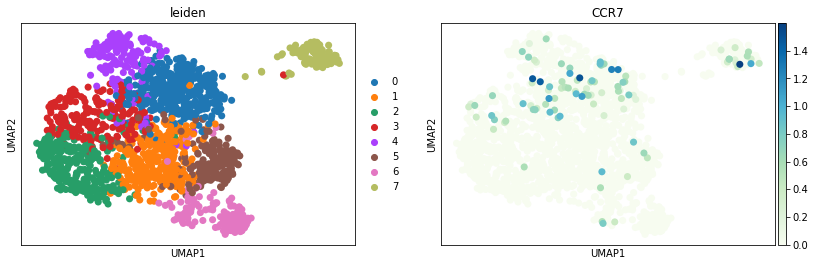

In [368]:
sc.pl.umap(adata[adata.obs['group'] == 'tumor'], color = ['leiden', 'CCR7'], size = 200, color_map = 'GnBu')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [16]:
adata.uns['celltype_colors']

array(['#1c4481', '#60688d', '#1f77b4'], dtype=object)

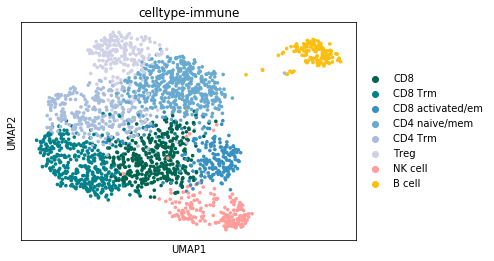

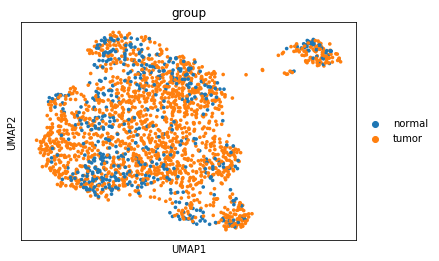

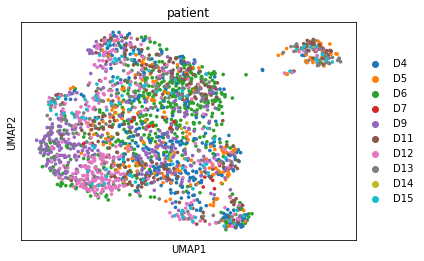

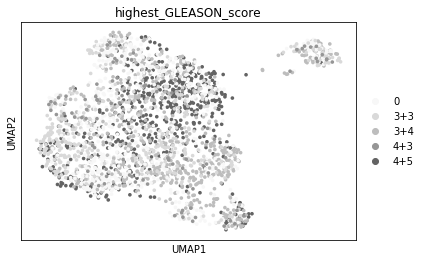

In [18]:
immune_dict = {'0':'CD4 naive/mem','1':'CD8','2':'CD8 Trm','3':'CD4 Trm','4':'Treg','5':'CD8 activated/em','6':'NK cell','7':'B cell'}
adata.obs['celltype-immune'] = [immune_dict[c] for c in adata.obs['leiden']]
adata.obs['celltype-immune'] = adata.obs['celltype-immune'].astype('category')
adata.obs['celltype-immune'].cat.reorder_categories(['CD8', 'CD8 Trm', 'CD8 activated/em', 'CD4 naive/mem', 'CD4 Trm', 'Treg', 'NK cell', 'B cell'], inplace=True)
if not os.path.exists('figures/umap'):
    os.makedirs('figures/umap')
sc.pl.umap(adata, color = ['celltype-immune'], save = '/lymphoid_celltypes.pdf', palette = ['#016450','#02818a','#3690c0','#67a9cf','#a6bddb','#d0d1e6','#ff9d9a','#fcbf10'])
sc.pl.umap(adata, color = ['group'], save = '/lymphoid_group.pdf')
sc.pl.umap(adata, color = ['patient'], save = '/lymphoid_patient.pdf')
sc.pl.umap(adata, color = ['highest_GLEASON_score'], save = '/lymphoid_gleason.pdf', palette = ['#f7f7f7', '#d9d9d9', '#bdbdbd', '#969696', '#636363'])

In [2]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype-immune', method = 'wilcoxon', n_genes=30000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


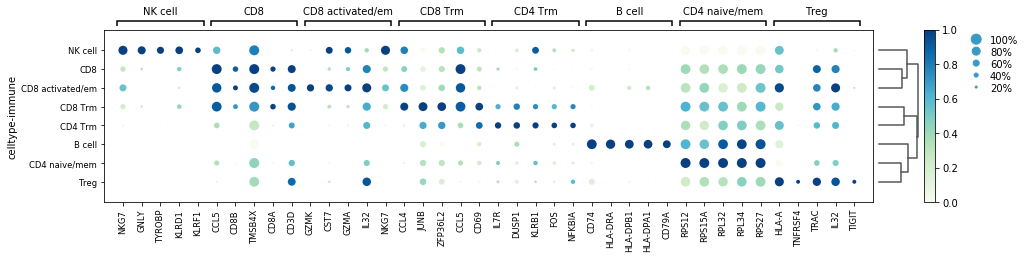

In [11]:
if not os.path.exists('figures/dotplot'):
    os.makedirs('figures/dotplot')
sc.pl.rank_genes_groups_dotplot(adata, 
                                n_genes = 5, 
                                color_map = 'GnBu', 
                                standard_scale = 'var', 
                                save = '/lymphoid_rank_gene_dotplot.pdf',
                                var_group_rotation = 0)

In [21]:
# save this file
adata.write(results_file, compression = 'gzip')

In [27]:
# try gene set test with Dona Farber's recent paper
adata2 = adata[adata.obs['celltype-immune'].isin(['CD8', 'CD8 Trm', 'CD8 activated/em', 'CD4 naive/mem', 'CD4 Trm', 'Treg'])]
modules = pd.read_csv('dataset/Szabo et al T cell gene module.txt', sep = '\t')
for gs in modules.columns:
    sc.tl.score_genes(adata2, modules[gs], score_name = str(gs)+'_score', use_raw=True)

computing score 'Treg_score'


Trying to set attribute `.obs` of view, making a copy.


    finished: added
    'Treg_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 NV/CM rest_score'
    finished: added
    'CD4 NV/CM rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4/CD8 rest_score'
    finished: added
    'CD4/CD8 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'IFN Response_score'
    finished: added
    'IFN Response_score', score of gene set (adata.obs) (0:00:00)
computing score 'Proliferation_score'
    finished: added
    'Proliferation_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytotoxic_score'
    finished: added
    'CD8 Cytotoxic_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytokine_score'
    finished: added
    'CD8 Cytokine_score', score of gene set (adata.obs) (0:00:00)


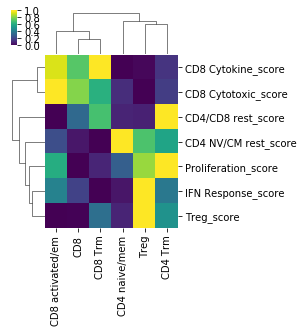

In [33]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['celltype-immune'] + [str(gs)+'_score' for gs in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetX = subset[subset['celltype-immune'] == x]
    outdict = {}
    for k in [str(gs)+'_score' for gs in modules.columns]:
        out = {k:np.mean(subsetX[k])}
        outdict.update(out)
    output = output.append(outdict, ignore_index=True)
output.index = list1
g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score.pdf')

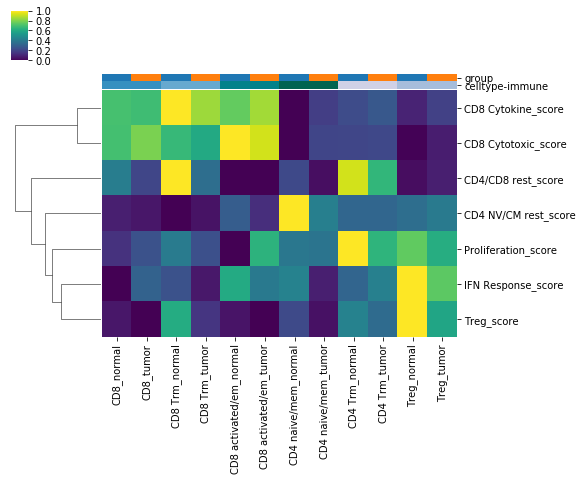

In [45]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, len(list1)) for x in adata2.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata2.uns['celltype-immune_colors']) + list(adata2.uns['celltype-immune_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'celltype-immune']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['CD8_normal', 'CD8_tumor', 'CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 activated/em_normal', 'CD8 activated/em_tumor', 'CD4 naive/mem_normal', 'CD4 naive/mem_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_split.pdf')

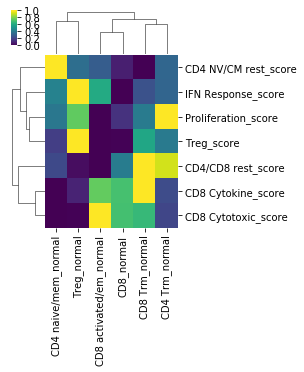

In [49]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_normal.pdf')

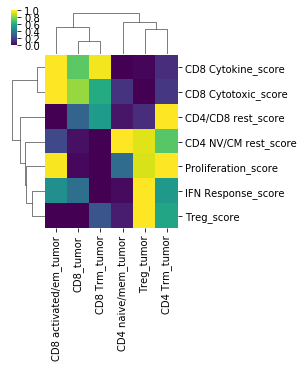

In [48]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outT = {k:np.mean(subsetT[k])}
        outdictT.update(outT)
    output = output.append(outdictT, ignore_index=True)
output.index = [l + '_tumor' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_tumor.pdf')

In [54]:
Kumar_Trm_signature = {'CD69+Trm':['CA10','ITGAE1','ITGAE','IL2','IL10','CXCR6','CXCL13','KCNK5','RGS1','CRTAM','DUSP6','PDCD1','IL23R'],
    'CD69-Trm':['STK38','TTC16','SELL','KLF3','KLF2','D4S234E','SBK1','FAM65B','TTYH2','NPDC1','KRT72','S1PR1','SOX13','KRT73','TSPAN18','PTGDS','RAP1GAP2','CX3CR1']}
Mackay_Trm_signature={
    'Trm':['INSIG1', 'DDX3X', 'DHCR24', 'PPP1R16B', 'KLF6', 'BTG2', 'CXCR6', 'FOSB', 'JUN', 'HSPA5', 'NEDD4', 'PLK3', 'STARD4', 'TNFAIP3', 'B4GALNT4', 'IRF4', 'CISH', 'MAPKAPK3', 'SIK1', 'PYGL', 'CTNNA1', 'ODC1', 'PER1', 'DUSP1', 'ATF3', 'LDLRAD4', 'JUNB', 'NFKBID', 'FOSL2', 'RGS2', 'NR4A2', 'DGAT1', 'ARRDC3', 'FRMD4B', 'NR4A1', 'GPR171', 'SMIM3', 'EYA2', 'GPR55', 'AL662899.4', 'CSRNP1', 'TRAF4', 'ZFP36', 'GLRX', 'DUSP5', 'LITAF', 'GADD45B', 'IFNG', 'OSGIN1', 'ABI3', 'EGR1', 'HILPDA', 'SKIL', 'RNF149', 'HMGCS1', 'P4HB', 'PNRC1', 'GPR34', 'PPP1R15A', 'ITGAE', 'P2RY10', 'EHD1', 'DUSP6', 'XCL2', 'SPSB1', 'ISG20', 'INPP4B', 'NEURL3', 'HPGDS', 'RHOB', 'VDAC1', 'LAD1', 'FOS', 'CDH1', 'CD69', 'QPCT', 'HSPD1'],
    'Tcm/Tem':['HBA2', 'C19orf38', 'SNX10', 'HAAO', 'POGK', 'SBK1', 'KLF2', 'BCL9L', 'THAP7', 'ASRGL1', 'ELMO1', 'HEXB', 'RACGAP1', 'CXCR4', 'CDC25B', 'LFNG', 'S1PR5', 'ARHGAP26', 'MPND', 'KCNAB2', 'ATP1B3', 'S1PR4', 'TMEM71', 'KBTBD11', 'EMB', 'MS4A4A', 'GRAMD4', 'EHD3', 'KCNN4', 'TCF7', 'MS4A4A', 'PAQR7', 'FAM89B', 'LYST', 'GLIPR2', 'EML3', 'S1PR1', 'PIK3R5', 'SETX', 'TXNDC5', 'NCLN', 'STK38', 'ITGA4', 'CCL5', 'CD84', 'KLF3', 'ABTB2', 'TBXA2R', 'LYRM2', 'OBP2B', 'ACP5', 'PODNL1', 'LEF1', 'SH2D1A', 'PHF11', 'TSR3', 'GMFG', 'EOMES', 'GNPDA2', 'PDE2A', 'SIDT1', 'GAB3', 'TXK', 'AVEN', 'ICAM2', 'KLHL6', 'SAMHD1', 'SMPDL3B', 'TTC7B', 'C5orf30', 'ATP10D', 'ST3GAL1', 'VOPP1', 'PCED1B', 'DOCK2', 'ITGB1', 'FAM117A', 'IL10RA', 'LPIN1', 'RBM43', 'ARHGEF18', 'RASA3', 'ABHD8', 'FAM49A', 'RASGRP2', 'B3GAT3', 'PRKCQ', 'XRN2']}
tcell_markers = {
    'CD4 rest':['TCF7', 'ID3', 'CCR7', 'AQP3', 'SELL'],
    'CD4 act\n':['IL4R', 'STAT1', 'MAL', 'SOCS1', 'IL2', 'ODC1', 'PSAT1', 'WARS', 'PYCR1', 'TNF', 'MIR155HG', 'NME1'],
    'CD4 Trm rest':['IFI6', 'LGALS3'],
    'CD4 Trm act\n':['MAF', 'TNFRSF18'],
    'CD8 EM/Trm rest':['KLRB1', 'JAML'],
    'CD8 Trm rest\n':['PDZD8', 'CXCR6', 'RCAN2', 'PRF1', 'ANXA2', 'CRIP1', 'ITGA1'],
    'CD8 EM/Trm act':['GZMB', 'IFNG', 'HOPX', 'CCL4', 'CCL3', 'XCL1', 'NKG7', 'GZMK', 'PRF1', 'GNLY', 'IFIT3', 'KLRD1', 'MYO1F', 'CCL5', 'GZMH', 'XCL2']}

In [55]:
for gs in Kumar_Trm_signature:
    sc.tl.score_genes(adata2, Kumar_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in Mackay_Trm_signature:
    sc.tl.score_genes(adata2, Mackay_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in tcell_markers:
    sc.tl.score_genes(adata2, tcell_markers[gs], score_name = str(gs)+'_score', use_raw=True)

computing score 'CD69+Trm_score'
    finished: added
    'CD69+Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD69-Trm_score'
    finished: added
    'CD69-Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Trm_score'
    finished: added
    'Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Tcm/Tem_score'
    finished: added
    'Tcm/Tem_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 rest_score'
    finished: added
    'CD4 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 act\n_score'
    finished: added
    'CD4 act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm rest_score'
    finished: added
    'CD4 Trm rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm act\n_score'
    finished: added
    'CD4 Trm act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 EM/Trm rest_score'
    finished: added
    'CD8 EM/

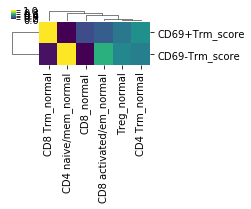

In [56]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in Kumar_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Kumar_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Kumar_Trm_geneset_score_normal.pdf')

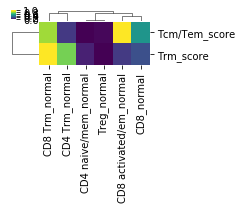

In [57]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in Mackay_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Mackay_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Mackay_Trm_geneset_score_normal.pdf')

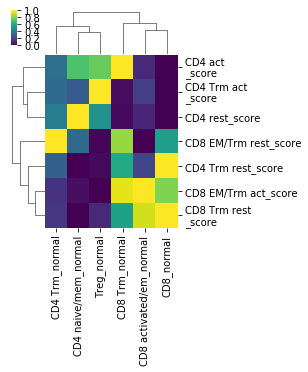

In [59]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in tcell_markers]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in tcell_markers]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_tcell_marker_score_normal.pdf')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
# test geneset NK cell mediated cytotoxicity from GO
modules = {'NK cell-mediated cytotoxicity':['AP1G1', 'ARRB2', 'CADM1', 'CD160', 'CD226', 'CEACAM1', 'CEBPG', 'CLEC12B', 'CLEC2A', 'CORO1A', 'CRK', 'CRTAM', 'GZMB', 'HAVCR2', 'HLA-B', 'HLA-E', 'HLA-F', 'HLA-G', 'IL12A', 'IL12B', 'IL18', 'IL18RAP', 'IL21', 'KIR2DL4', 'KIR3DL1', 'KLRF2', 'KLRK1', 'LAG3', 'LAMP1', 'LEP', 'LGALS9', 'LILRB1', 'LYST', 'MICA', 'NCR1', 'NCR3', 'NECTIN2', 'PIK3R6', 'PRDX1', 'PTPN6', 'PVR', 'RAB27A', 'RAET1E', 'RAET1G', 'RASGRP1', 'SERPINB4', 'SERPINB9', 'SH2D1A', 'SLAMF6', 'SLAMF7', 'STAT5B', 'TUBB', 'TUBB4B', 'ULBP1', 'ULBP2', 'ULBP3', 'UNC13D', 'VAMP2', 'VAMP7', 'VAV1'],
'T cell-mediated cytotoxicity':['AGER', 'AZGP1', 'B2M', 'CADM1', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CEACAM1', 'CRTAM', 'CTSC', 'CTSH', 'EMP2', 'FADD', 'FAM49B', 'FCGR2B', 'FCGRT', 'GZMM', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'HPRT1', 'IL12A', 'IL12B', 'IL12RB1', 'IL23A', 'IL23R', 'IL7R', 'LILRB1', 'MICA', 'MICB', 'NECTIN2', 'P2RX7', 'PPP3CB', 'PRF1', 'PTPRC', 'PVR', 'RAB27A', 'RIPK3', 'STX7', 'TSTA3', 'XCL1']}

In [3]:
for m in modules:
    sc.tl.score_genes(adata, modules[m], score_name = str(m)+'_score', use_raw=True)
ndata = adata[adata.obs['group']=='normal']
tdata = adata[adata.obs['group']=='tumor']

computing score 'NK cell-mediated cytotoxicity_score'
    finished: added
    'NK cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)
computing score 'T cell-mediated cytotoxicity_score'
    finished: added
    'T cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)


In [4]:
adata.obs['celltype-immune_group'] = [b+'_'+a for a,b in zip(adata.obs['group'], adata.obs['celltype-immune'])]
adata.obs['celltype-immune_group'] = adata.obs['celltype-immune_group'].astype('category')
adata.obs['celltype-immune_group'].cat.reorder_categories(['CD8_normal', 'CD8_tumor', 'CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 activated/em_normal', 'CD8 activated/em_tumor', 'CD4 naive/mem_normal', 'CD4 naive/mem_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor', 'NK cell_normal', 'NK cell_tumor', 'B cell_normal', 'B cell_tumor'], inplace=True)

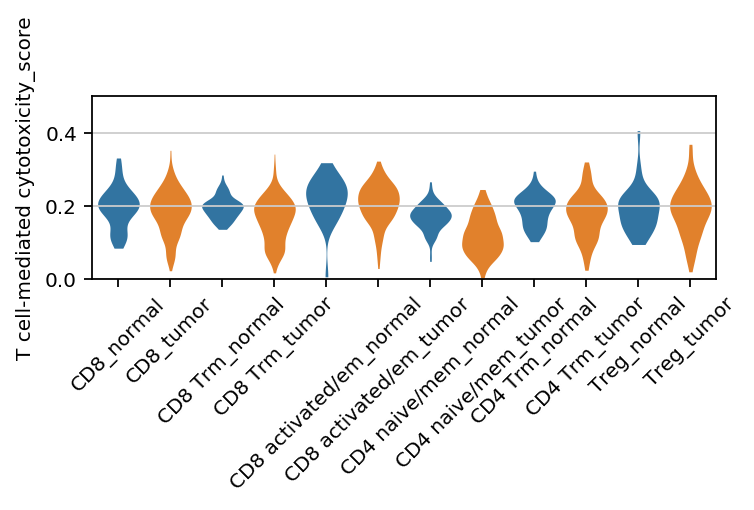

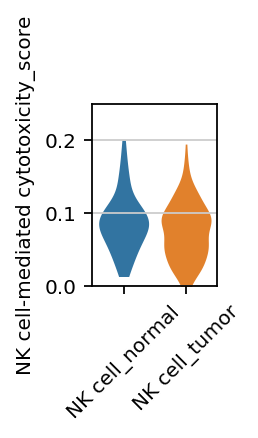

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(5,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(adata[~adata.obs['celltype-immune'].isin(['NK cell', 'B cell'])], ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity.pdf')
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(adata[adata.obs['celltype-immune'].isin(['NK cell'])], ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity.pdf')

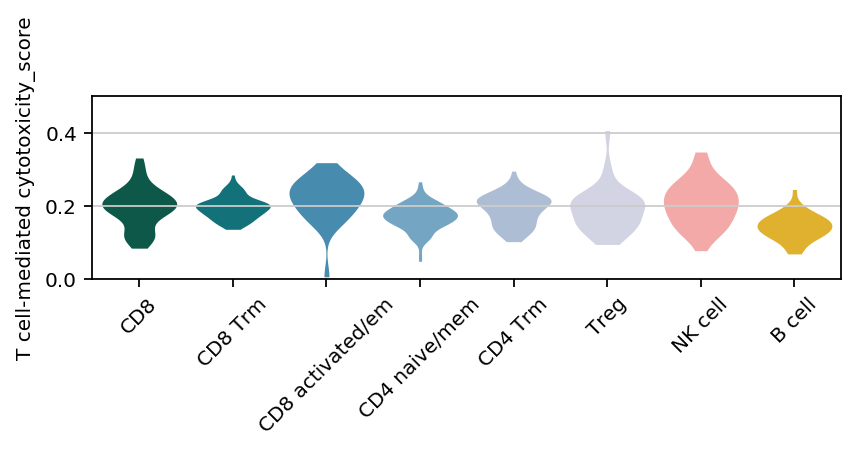

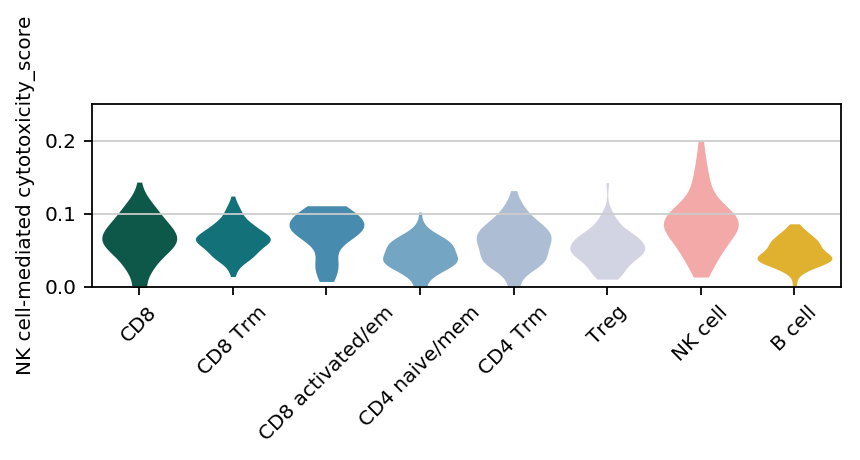

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(6,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(ndata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_normal.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(ndata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_normal.pdf')

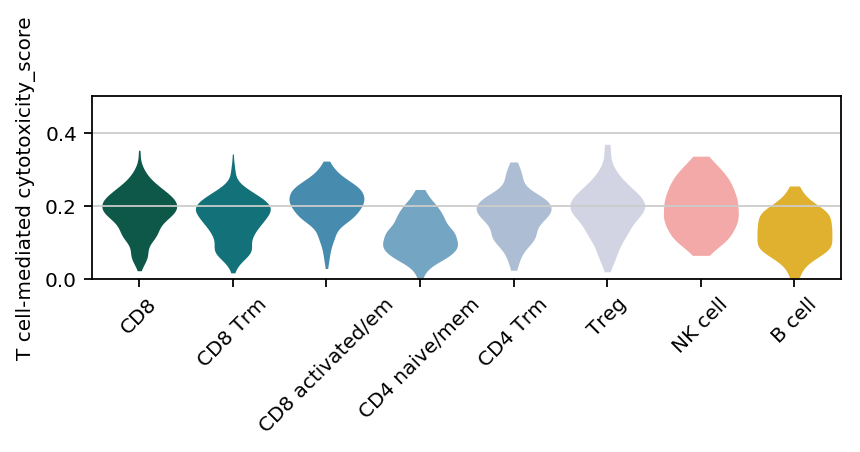

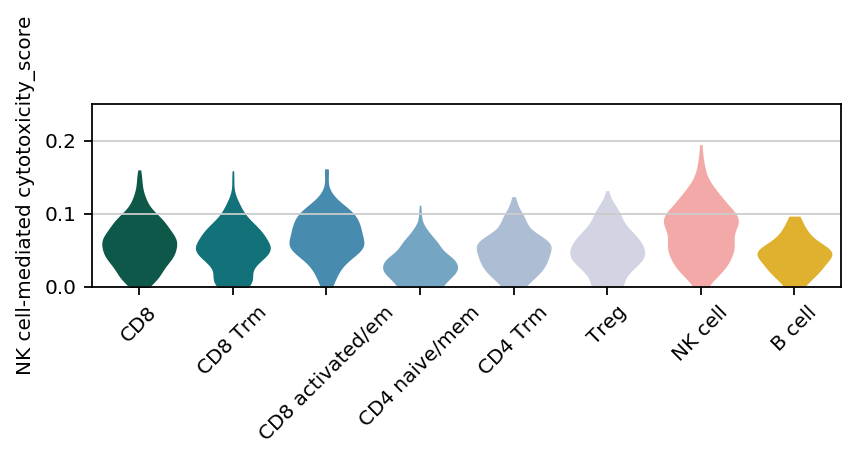

In [12]:
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(tdata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_tumor.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(tdata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_tumor.pdf')

In [71]:
adata2.obs.to_csv('figures/violin/cytotoxicity_score.csv')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

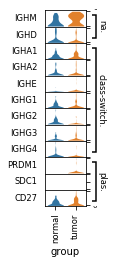

In [67]:
bdata = adata[adata.obs['celltype'] == 'B cell']
sc.pl.stacked_violin(bdata, 
              {'naive':['IGHM', 'IGHD'], 
               'class-switched':['IGHA1', 'IGHA2', 'IGHE', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'],
               'plasma cell':['PRDM1', 'SDC1', 'CD27']},
              groupby = 'group',
              standard_scale = 'var',
              swap_axes = True,
              color_map = 'viridis',
              var_group_rotation = 0,
              linewidth = 0,
              save = '/immunogobulins_Bcell normal tumor.pdf',
              palette = bdata.uns['group_colors'])

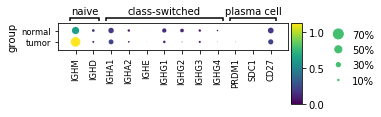

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [70]:
sc.pl.dotplot(bdata, 
              {'naive':['IGHM', 'IGHD'], 
               'class-switched':['IGHA1', 'IGHA2', 'IGHE', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'],
               'plasma cell':['PRDM1', 'SDC1', 'CD27']},
              groupby = 'group',
              color_map = 'viridis',
              var_group_rotation = 0,
              save = '/immunogobulins_Bcell normal tumor.pdf')

In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [20]:
# subset to B cells
adata = adata[adata.obs['celltype-immune'] == 'B cell']

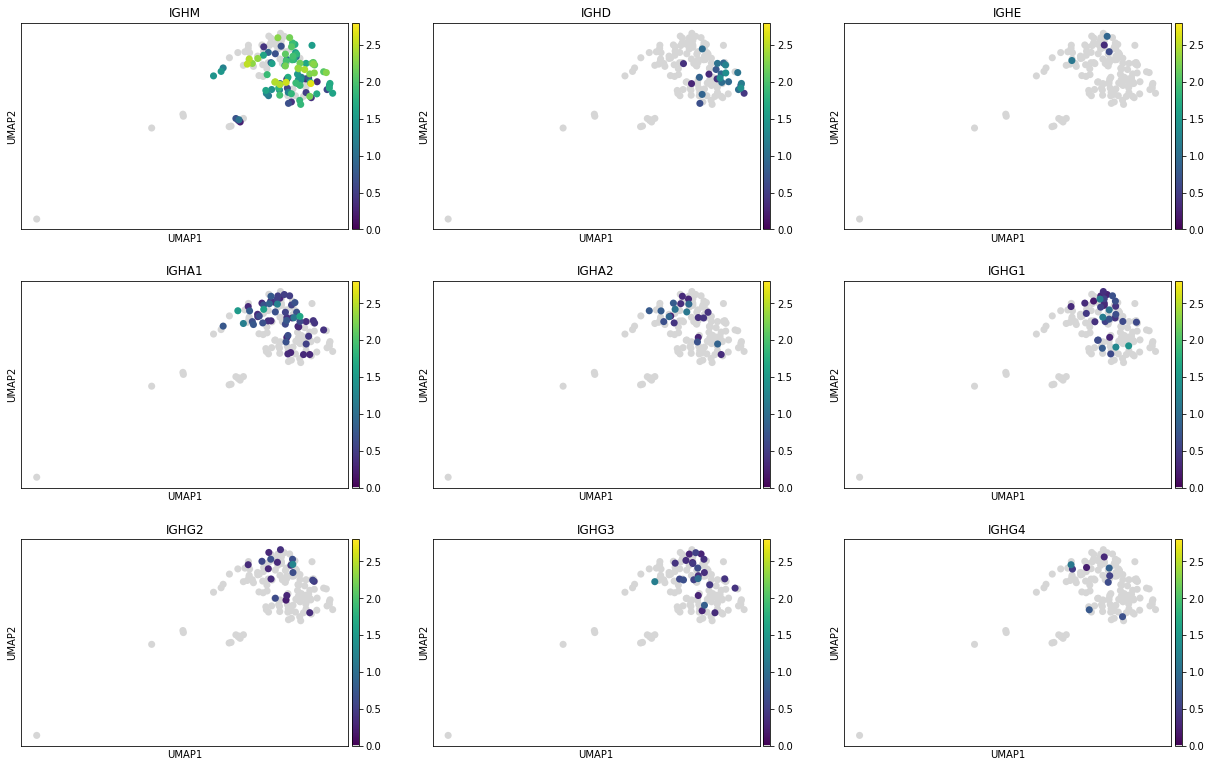

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

sc.pl.umap(adata, color = ['IGHM', 'IGHD', 'IGHE', 'IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell ImmunoGobulins.pdf')

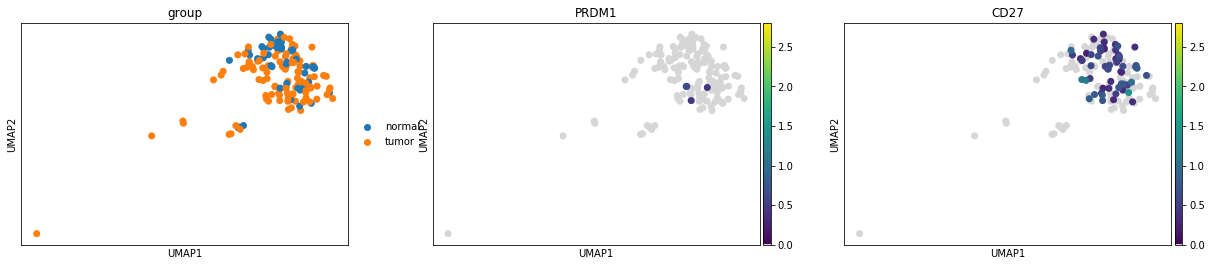

In [22]:
sc.pl.umap(adata, color = ['group', 'PRDM1', 'CD27'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell plasma.pdf')

In [23]:
module = ['MARCH1', 'MARCH8', 'ABCB9', 'ACE', 'ACTR10', 'ACTR1A', 'ACTR1B', 'AP1B1', 'AP1G1', 'AP1M1', 'AP1M2', 'AP1S1', 'AP1S2', 'AP1S3', 'AP2A1', 'AP2A2', 'AP2B1', 'AP2M1', 'AP2S1', 'AP3B1', 'AP3D1', 'ARF1', 'ATG5', 'AZGP1', 'B2M', 'BCAP31', 'CALR', 'CANX', 'CAPZA1', 'CAPZA2', 'CAPZA3', 'CAPZB', 'CCL19', 'CCL21', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD207', 'CD209', 'CD36', 'CD68', 'CD74', 'CD8A', 'CENPE', 'CHUK', 'CLEC4A', 'CLEC4M', 'CLTA', 'CLTC', 'CTSD', 'CTSE', 'CTSF', 'CTSH', 'CTSL', 'CTSS', 'CTSV', 'CYBA', 'CYBB', 'DCTN1', 'DCTN2', 'DCTN3', 'DCTN4', 'DCTN5', 'DCTN6', 'DNM2', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNLL1', 'DYNLL2', 'E7ENX8', 'ERAP1', 'ERAP2', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FCGR2B', 'FCGRT', 'FGL2', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'ICAM1', 'IDE', 'IFI30', 'IKBKB', 'IKBKG', 'ITGAV', 'ITGB5', 'KIF11', 'KIF15', 'KIF18A', 'KIF22', 'KIF23', 'KIF26A', 'KIF2A', 'KIF2B', 'KIF2C', 'KIF3A', 'KIF3B', 'KIF3C', 'KIF4A', 'KIF4B', 'KIF5A', 'KIFAP3', 'KLC1', 'KLC2', 'LAG3', 'LGMN', 'LILRB2', 'LNPEP', 'MICA', 'MICB', 'MR1', 'NCF1', 'NCF2', 'NCF4', 'NOD1', 'NOD2', 'OSBPL1A', 'PDIA3', 'PSAP', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'PYCARD', 'RAB10', 'RAB27A', 'RAB32', 'RAB33A', 'RAB34', 'RAB35', 'RAB3B', 'RAB3C', 'RAB4A', 'RAB5B', 'RAB6A', 'RAB7A', 'RAB8B', 'RACGAP1', 'RELB', 'RFTN1', 'RILP', 'SAR1B', 'SEC13', 'SEC22B', 'SEC23A', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SH3GL2', 'SLC11A1', 'SNAP23', 'SPTBN2', 'TAP1', 'TAP2', 'TAPBP', 'TAPBPL', 'THBS1', 'TRAF6', 'TREM2', 'TREX1', 'VAMP3', 'VAMP8', 'WAS', 'YTHDF1']
sc.tl.score_genes(adata, module, score_name = 'Antigen processing and presentation_score', use_raw=True)

computing score 'Antigen processing and presentation_score'
    finished: added
    'Antigen processing and presentation_score', score of gene set (adata.obs) (0:00:00)


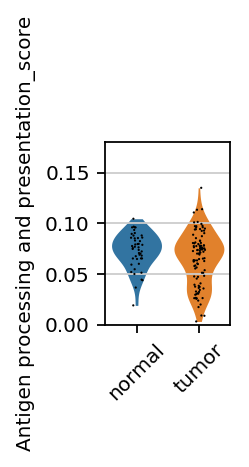

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
ax = sns.violinplot()
sc.pl.violin(adata, ['Antigen processing and presentation_score'], ax = ax, groupby = 'group', size = 1, standard_scale = 'var', linewidth = 0, rotation = 45, save = '/B cell_Antigen processing and presentation_score.pdf')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 2275 × 2046 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'highest_GLEASON_score_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

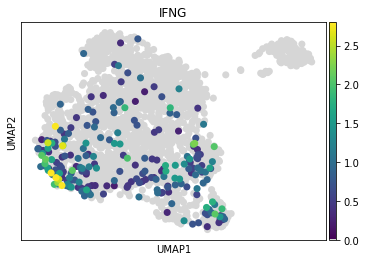

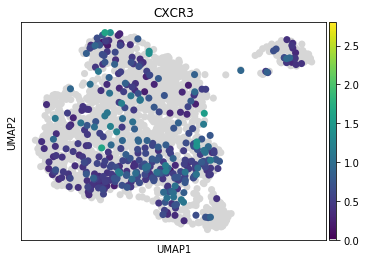

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

sc.pl.umap(adata, color = ['IFNG'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Lymphoid_IFNG_umap.pdf')
sc.pl.umap(adata, color = ['CXCR3'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Lymphoid_CXCR3_umap.pdf')

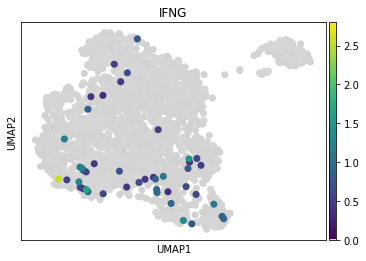

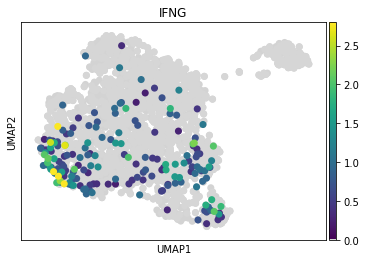

In [10]:
ax = sc.pl.umap(adata, show = False, size = 200)
sc.pl.umap(adata[adata.obs['group'] == 'normal'], vmax = 2.8, color = ['IFNG'], ax = ax, color_map = newcmp, size = 200)
ax = sc.pl.umap(adata, show = False, size = 200)
sc.pl.umap(adata[adata.obs['group'] == 'tumor'], vmax = 2.8, color = ['IFNG'], ax = ax, color_map = newcmp, size = 200)

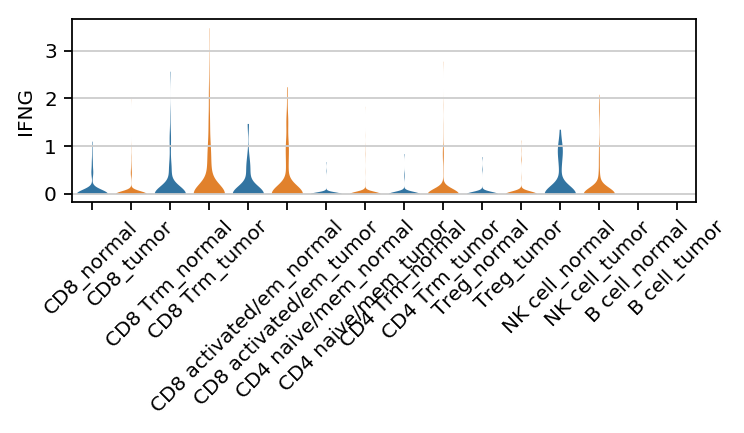

In [11]:
adata.obs['celltype-immune_group'] = [b+'_'+a for a,b in zip(adata.obs['group'], adata.obs['celltype-immune'])]
adata.obs['celltype-immune_group'] = adata.obs['celltype-immune_group'].astype('category')
adata.obs['celltype-immune_group'].cat.reorder_categories(['CD8_normal', 'CD8_tumor', 'CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 activated/em_normal', 'CD8 activated/em_tumor', 'CD4 naive/mem_normal', 'CD4 naive/mem_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor', 'NK cell_normal', 'NK cell_tumor', 'B cell_normal', 'B cell_tumor'], inplace=True)
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(5,1.5))
# plt.ylim(0,3)
ax = sns.violinplot()
sc.pl.violin(adata, ['IFNG'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Lymphoid_IFNG_violin.pdf')

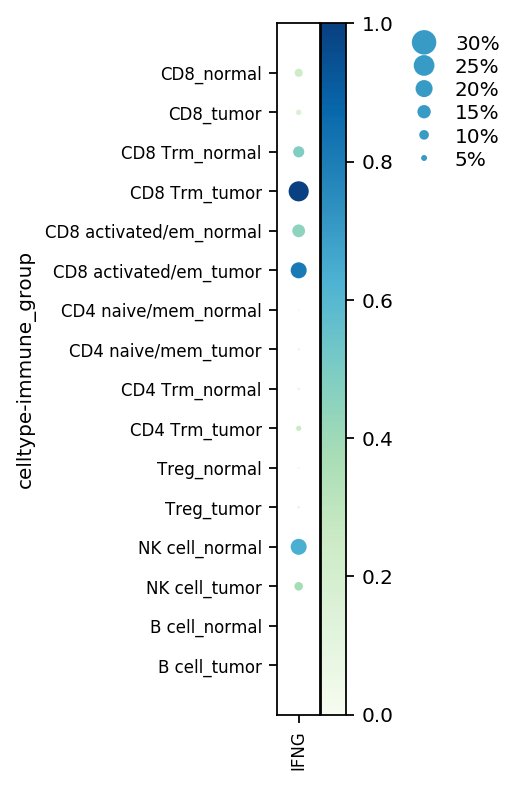

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.35, 0, 0.2, 0.5, 0.25])

In [17]:
sc.pl.dotplot(adata, ['IFNG'], groupby = 'celltype-immune_group', standard_scale = 'var', color_map = 'GnBu', save = '/Lymphoid_IFNG_dotplot.pdf')

In [12]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata
# try gene set test with Wherry exhaustion genesets
adata2 = adata[adata.obs['celltype-immune'].isin(['CD8', 'CD8 Trm', 'CD8 activated/em', 'CD4 naive/mem', 'CD4 Trm', 'Treg'])]
genesets = pd.read_csv('dataset/Mouse_exhaustion_genesets_converted.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(adata2, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1
computing score 'GSE26495 CD8+ PD-1lo UP_score'


Trying to set attribute `.obs` of view, making a copy.


    finished: added
    'GSE26495 CD8+ PD-1lo UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE26495 CD8+ PD-1hi UP_score'
    finished: added
    'GSE26495 CD8+ PD-1hi UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE41867 Chronic-acute CD8+ Up_score'
    finished: added
    'GSE41867 Chronic-acute CD8+ Up_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE41870 CD8+ LCMV Chronic-Acute UP_score'
    finished: added
    'GSE41870 CD8+ LCMV Chronic-Acute UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score'
    finished: added
    'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', score of gene set (adata.obs) (0:00:00)


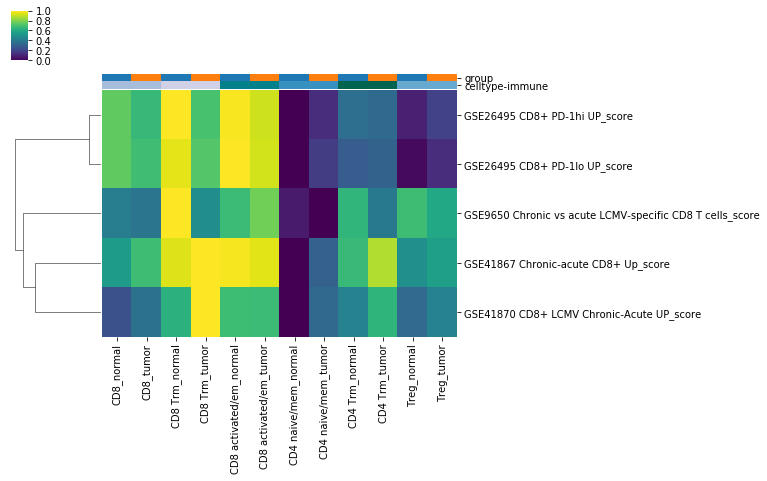

In [15]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in genesets.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in genesets.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, len(list1)) for x in adata2.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata2.uns['celltype-immune_colors']) + list(adata2.uns['celltype-immune_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'celltype-immune']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['CD8_normal', 'CD8_tumor', 'CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 activated/em_normal', 'CD8 activated/em_tumor', 'CD4 naive/mem_normal', 'CD4 naive/mem_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Wherry_ex_geneset_score_split.pdf')

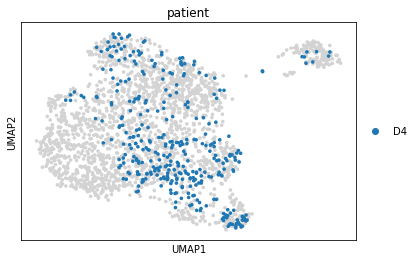

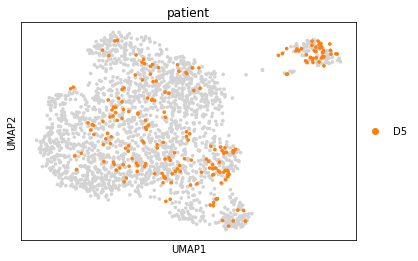

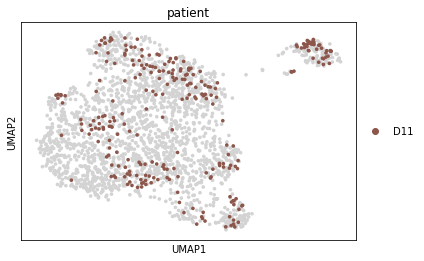

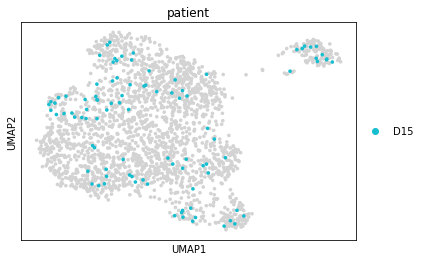

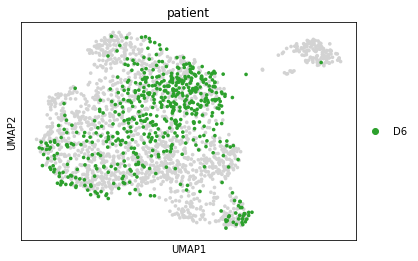

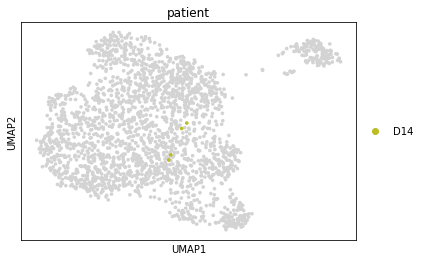

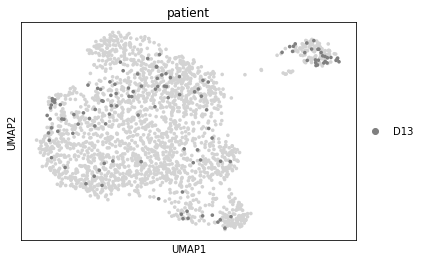

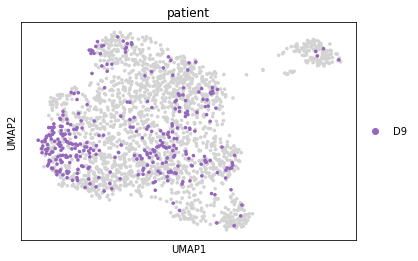

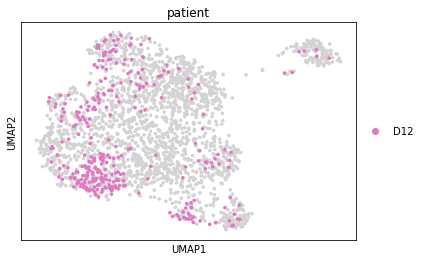

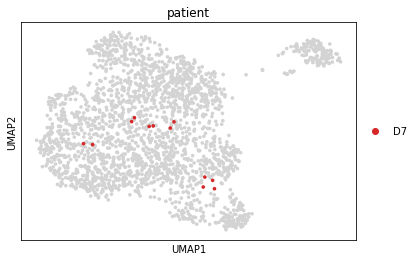

In [20]:
for p in list(set(adata.obs['patient'])):
    sc.pl.umap(adata, color = ['patient'], groups = p)

2020-03-30 12:09:14,819 Parsing data files for GSEA.............................
2020-03-30 12:09:15,119 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-30 12:09:15,120 0005 gene_sets used for further statistical testing.....
2020-03-30 12:09:15,121 Start to run GSEA...Might take a while..................
2020-03-30 12:09:16,933 Start to generate gseapy reports, and produce figures...
2020-03-30 12:09:16,943 Congratulations. GSEApy runs successfully................

2020-03-30 12:09:16,956 Parsing data files for GSEA.............................
2020-03-30 12:09:17,267 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-30 12:09:17,268 0005 gene_sets used for further statistical testing.....
2020-03-30 12:09:17,269 Start to run GSEA...Might take a while..................
2020-03-30 12:09:18,975 Start to generate gseapy reports, and produce figures...
2020-03-30 12:09:18,986 Congratulations. GSEApy runs successfully............